# **Mind the (Social) Gap**: How do the socio-economic conditions of people in the Netherlands affect their risk of depression and anxiety?


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import learning_curve

In order to explore the relationships between socio-economic factors and the prevalence of depression and anxiety in the Netherlands, this study uses neighborhood statistics from the CSB (2021) and data about the high risk of depression for people aged between 18 and 65 (RIVM 2022). The data was cleaned by removing 51 columns as they were empty for all observations, removing data points in which the population of a neighborhood was equal to zero, and imputing them and all other missing values through kNN imputation. For variables with a right skewed distribution, a cubic root transformation was applied to better align them with a standard distribution, while variables with a perfect correlation (of ± 1) were removed to reduce redundancy.


Exploratory Data Analysis was conducted to understand and visualize the correlations between the features in the CSB dataset and the target variable “HoogRisicoOpAngstOfDepressie_25”. To further explore these connections, the study uses different regressors, namely a linear and a Ridge regression — both with standard scaling — as well as a Decision Tree regression, which also allows for the analysis of feature importance. The merged dataset is also examined through unsupervised learning through the implementation of an isolation forest for outlier detection, visualized using PCA reduction.  

In [ ]:
# Load the RIVM dataset regarding the risk of anxiety and depression
df1 = pd.read_csv("HoogRisicoOpAngst.csv", sep=';')
pd.set_option('display.max_columns', None)
df1 = df1.drop(["ID", "Leeftijd", "Perioden", "Marges"], axis=1)
df1.rename(columns={"WijkenEnBuurten": "gwb_code"}, inplace=True)
df1.head()

,gwb_code,HoogRisicoOpAngstOfDepressie_25
0,NL01,12.0
1,GM1680,8.0
2,WK168000,6.8
3,BU16800000,6.9
4,BU16800009,4.9


Since an overview of the dataset showed that these columns only consisted of missing data, they were removed.

In [ ]:
# Load the CBS dataset
df2 = pd.read_csv("kwb-2021.csv")
columns_to_remove = ['g_ele', 'g_ele_ap', 'g_ele_tw', 'g_ele_hw', 'g_ele_2w', 'g_ele_vw', 'g_ele_hu', 'g_ele_ko',
    'g_gas', 'g_gas_ap', 'g_gas_tw', 'g_gas_hw', 'g_gas_2w', 'g_gas_vw', 'g_gas_hu', 'g_gas_ko',
    'p_stadsv', 'a_opl_lg', 'a_opl_md', 'a_opl_hg', 'p_arb_pp', 'p_arb_wn', 'p_arb_zs', 'a_inkont',
    'g_ink_po', 'g_ink_pi', 'p_ink_li', 'p_ink_hi', 'g_hh_sti', 'p_hh_li', 'p_hh_hi', 'p_hh_lkk',
    'p_hh_osm', 'p_hh_110', 'p_hh_120', 'm_hh_ver', 'a_soz_wb', 'a_soz_ao', 'a_soz_ww', 'a_soz_ow',
    'a_jz_tn', 'p_jz_tn', 'a_wmo_t', 'p_wmo_t', "g_afs_hp" , "g_pau_hh", "g_afs_hp", "g_afs_gs", "g_afs_kv", "g_afs_sc", "g_3km_sc"]

df2 = df2.drop(columns=columns_to_remove)
df2.head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,ind_wbi,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,a_gehuwd,a_gesch,a_verwed,a_w_all,a_nw_all,a_marok,a_antaru,a_suri,a_tur,a_ov_nw,a_geb,p_geb,a_ste,p_ste,a_hh,a_1p_hh,a_hh_z_k,a_hh_m_k,g_hhgro,bev_dich,a_woning,g_woz,p_1gezw,p_mgezw,p_bewndw,p_leegsw,p_koopw,p_huurw,p_wcorpw,p_ov_hw,p_e_o_w,p_bjj2k,p_bjo2k,a_bedv,a_bed_a,a_bed_bf,a_bed_gi,a_bed_hj,a_bed_kl,a_bed_mn,a_bed_oq,a_bed_ru,a_pau,a_bst_b,a_bst_nb,g_pau_km,a_m2w,a_opp_ha,a_lan_ha,a_wat_ha,pst_mvp,pst_dekp,ste_mvs,ste_oad
0,NL00,0,Nederland,Nederland,Land,NL00,.,17475415,8686536,8788879,2711731,2139221,4347005,4819923,3457535,8558739,6678969,1377923,859784,1858730,2447178,414186,171413,358266,422030,1081283,179441,10,170972,10,8043443,3097117,2331454,2614872,"2,1",519,7966331,290,64,36,96,4,57,43,29,14,0,82,18,2104540,77875,289660,364075,156870,168595,478950,332725,235795,8793590,7059980,1733615,261,700100,4154338,3367109,787228,.,.,2,2024
1,GM0014,14,Groningen,Groningen,Gemeente,GM0014,.,233273,116177,117096,28437,49538,69799,50403,35096,153241,55478,16374,8180,29771,28507,1278,4077,3367,1771,18014,2233,10,1846,8,136508,80059,30882,25567,"1,7",1257,118922,226,40,60,96,4,40,59,33,27,0,83,17,26220,200,2030,4255,2350,1765,6535,5135,3945,95295,72285,23010,513,6445,19796,18560,1236,.,.,1,3312
2,WK001400,1400,Centrum,Groningen,Wijk,WK001400,1,22735,11875,10860,630,9745,7790,2670,1905,19275,2075,1055,330,4310,2645,60,305,220,160,1895,85,4,100,4,17935,14360,2910,675,"1,3",10059,12546,219,14,86,92,8,16,84,27,57,0,86,14,4510,5,195,1190,385,275,970,605,885,4220,3235,980,1869,390,241,226,16,.,.,1,6353
3,BU00140000,140000,Binnenstad-Noord,Groningen,Buurt,BU00140000,1,4510,2380,2125,80,2120,1560,475,270,3945,350,175,45,845,470,10,50,50,30,340,15,4,10,2,3640,2975,575,90,"1,2",12192,2257,222,13,87,90,10,13,87,21,67,0,95,5,975,5,35,320,95,60,200,115,150,760,555,205,2043,45,39,37,2,9712,1,1,6561
4,BU00140001,140001,Binnenstad-Zuid,Groningen,Buurt,BU00140001,1,6410,3405,3000,135,2945,2180,680,470,5580,475,285,75,1160,755,15,95,70,50,535,20,2,25,4,5140,4175,820,150,"1,2",11651,3562,225,9,91,89,11,13,87,27,60,1,96,4,1620,0,50,515,120,110,295,185,350,1050,780,270,1909,115,59,55,4,9711,1,1,6260


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17681 entries, 0 to 17680
Data columns (total 70 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   gwb_code_10  17681 non-null  object
 1   gwb_code_8   17681 non-null  int64 
 2   regio        17681 non-null  object
 3   gm_naam      17681 non-null  object
 4   recs         17681 non-null  object
 5   gwb_code     17681 non-null  object
 6   ind_wbi      17681 non-null  object
 7   a_inw        17681 non-null  int64 
 8   a_man        17681 non-null  int64 
 9   a_vrouw      17681 non-null  int64 
 10  a_00_14      17681 non-null  int64 
 11  a_15_24      17681 non-null  int64 
 12  a_25_44      17681 non-null  int64 
 13  a_45_64      17681 non-null  int64 
 14  a_65_oo      17681 non-null  int64 
 15  a_ongeh      17681 non-null  int64 
 16  a_gehuwd     17681 non-null  int64 
 17  a_gesch      17681 non-null  int64 
 18  a_verwed     17681 non-null  int64 
 19  a_w_all      17681 non-nu

Since not all numerical features have a numerical datatype (mainly because missing values in the dataset are represented by the string ".") it is necessary to convert them into numerical datatypes.

In [ ]:
df2['g_hhgro'] = df2.g_hhgro.str.split(',').str.join('.')

# Convert columns representing features into numeric, coercing errors to NaN
columns_to_convert = df2.columns.difference(['gwb_code_10', 'gwb_code_8', 'regio', 'gm_naam', 'recs', 'gwb_code'])
df2[columns_to_convert] = df2[columns_to_convert].apply(pd.to_numeric, errors='coerce')

In [ ]:
df_merged = df2.merge(df1, on="gwb_code", how = 'outer')

df_merged.head()

,gwb_code_10,gwb_code_8,regio,gm_naam,recs,gwb_code,ind_wbi,a_inw,a_man,a_vrouw,a_00_14,a_15_24,a_25_44,a_45_64,a_65_oo,a_ongeh,a_gehuwd,a_gesch,a_verwed,a_w_all,a_nw_all,a_marok,a_antaru,a_suri,a_tur,a_ov_nw,a_geb,p_geb,a_ste,p_ste,a_hh,a_1p_hh,a_hh_z_k,a_hh_m_k,g_hhgro,bev_dich,a_woning,g_woz,p_1gezw,p_mgezw,p_bewndw,p_leegsw,p_koopw,p_huurw,p_wcorpw,p_ov_hw,p_e_o_w,p_bjj2k,p_bjo2k,a_bedv,a_bed_a,a_bed_bf,a_bed_gi,a_bed_hj,a_bed_kl,a_bed_mn,a_bed_oq,a_bed_ru,a_pau,a_bst_b,a_bst_nb,g_pau_km,a_m2w,a_opp_ha,a_lan_ha,a_wat_ha,pst_mvp,pst_dekp,ste_mvs,ste_oad,HoogRisicoOpAngstOfDepressie_25
0,BU00140000,140000.0,Binnenstad-Noord,Groningen,Buurt,BU00140000,1.0,4510.0,2380.0,2125.0,80.0,2120.0,1560.0,475.0,270.0,3945.0,350.0,175.0,45.0,845.0,470.0,10.0,50.0,50.0,30.0,340.0,15.0,4.0,10.0,2.0,3640.0,2975.0,575.0,90.0,1.2,12192.0,2257.0,222.0,13.0,87.0,90.0,10.0,13.0,87.0,21.0,67.0,0.0,95.0,5.0,975.0,5.0,35.0,320.0,95.0,60.0,200.0,115.0,150.0,760.0,555.0,205.0,2043.0,45.0,39.0,37.0,2.0,9712.0,1.0,1.0,6561.0,16.0
1,BU00140001,140001.0,Binnenstad-Zuid,Groningen,Buurt,BU00140001,1.0,6410.0,3405.0,3000.0,135.0,2945.0,2180.0,680.0,470.0,5580.0,475.0,285.0,75.0,1160.0,755.0,15.0,95.0,70.0,50.0,535.0,20.0,2.0,25.0,4.0,5140.0,4175.0,820.0,150.0,1.2,11651.0,3562.0,225.0,9.0,91.0,89.0,11.0,13.0,87.0,27.0,60.0,1.0,96.0,4.0,1620.0,0.0,50.0,515.0,120.0,110.0,295.0,185.0,350.0,1050.0,780.0,270.0,1909.0,115.0,59.0,55.0,4.0,9711.0,1.0,1.0,6260.0,16.4
2,BU00140002,140002.0,Binnenstad-Oost,Groningen,Buurt,BU00140002,1.0,4170.0,2190.0,1980.0,120.0,1755.0,1460.0,480.0,355.0,3565.0,345.0,205.0,55.0,750.0,600.0,25.0,65.0,45.0,25.0,430.0,20.0,5.0,15.0,4.0,3310.0,2610.0,565.0,130.0,1.3,15441.0,2638.0,191.0,14.0,86.0,94.0,6.0,11.0,89.0,32.0,56.0,0.0,79.0,21.0,590.0,0.0,35.0,110.0,50.0,35.0,145.0,110.0,105.0,740.0,575.0,165.0,2762.0,60.0,29.0,27.0,2.0,9711.0,3.0,1.0,6037.0,19.6
3,BU00140003,140003.0,Binnenstad-West,Groningen,Buurt,BU00140003,1.0,1720.0,940.0,780.0,35.0,645.0,705.0,165.0,165.0,1445.0,185.0,55.0,30.0,335.0,165.0,10.0,10.0,10.0,10.0,130.0,10.0,6.0,5.0,3.0,1390.0,1115.0,230.0,45.0,1.2,17200.0,1007.0,226.0,12.0,88.0,93.0,7.0,14.0,86.0,16.0,70.0,0.0,97.0,3.0,295.0,0.0,10.0,65.0,25.0,20.0,80.0,35.0,55.0,380.0,305.0,75.0,3891.0,45.0,11.0,10.0,1.0,9718.0,1.0,1.0,6145.0,15.5
4,BU00140004,140004.0,Noorderplantsoen,Groningen,Buurt,BU00140004,1.0,10.0,5.0,5.0,0.0,0.0,0.0,5.0,5.0,5.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,5.0,0.0,5.0,1.8,65.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,20.0,17.0,3.0,9717.0,2.0,1.0,6200.0,6.8


In [ ]:
df = df_merged.loc[df_merged["recs"] == "Buurt"].copy()

## Exploratory Data Analysis

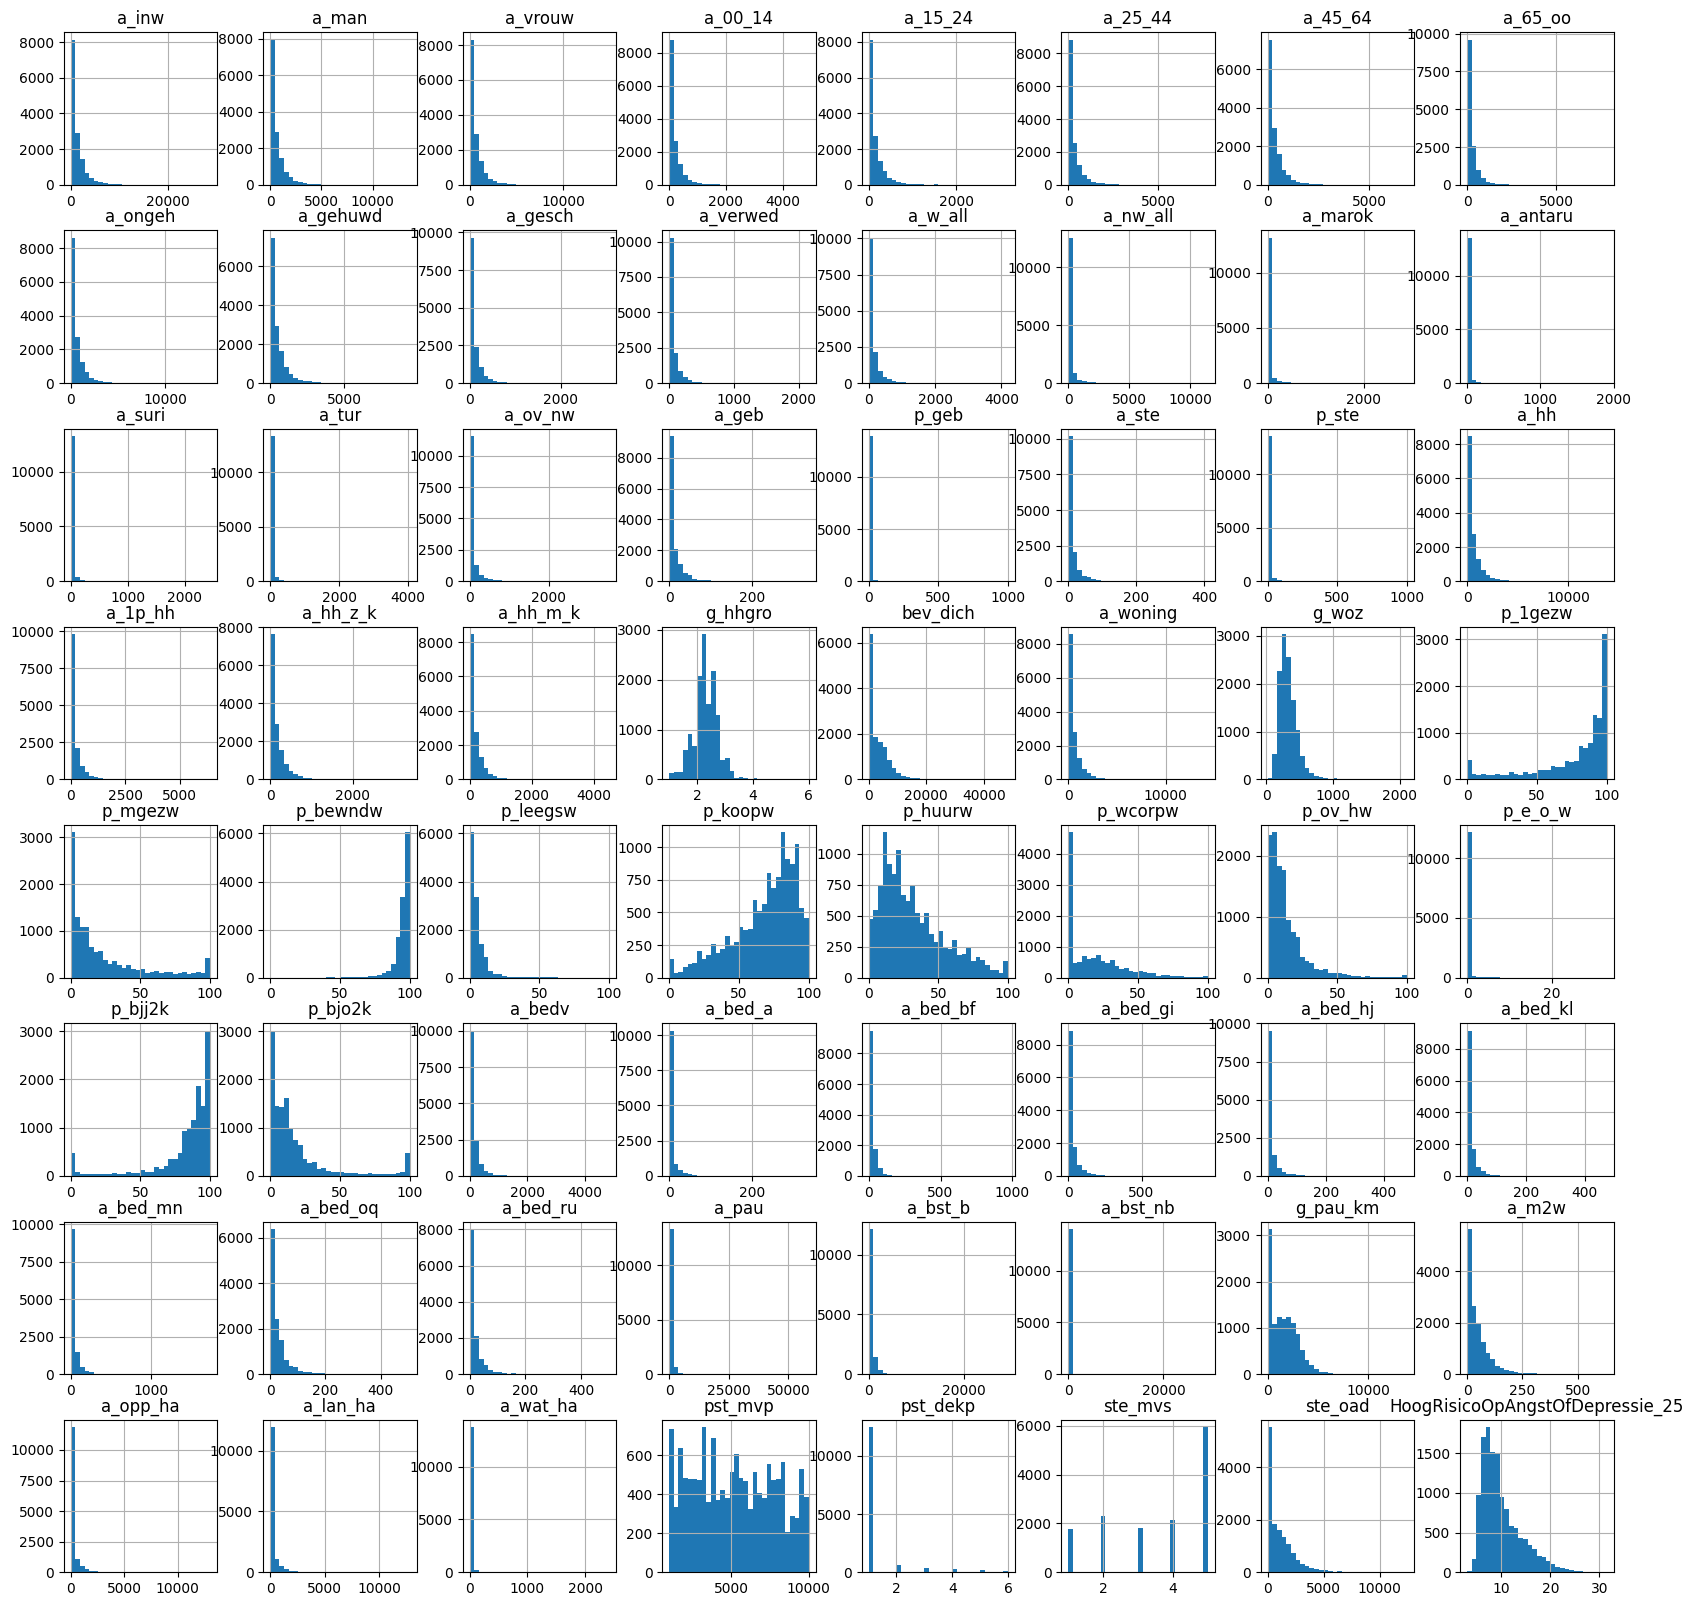

In [ ]:
plots = df.iloc[:, 7:].hist(figsize=(20, 20), bins=30)
plt.show()

Values of 0 in some variables regarding demographics were treated as missing, as it is unlikely that they represent actual zeros.

In [ ]:
from sklearn.impute import KNNImputer

columns_not_zero = ["a_vrouw", "a_man", "a_inw", "a_00_14", "a_15_24", "a_25_44", "a_45_64", "a_ongeh", "a_gehuwd", "a_gesch", "a_verwed"]

# Replace 0 with NaN in the specified columns
df[columns_not_zero] = df[columns_not_zero].replace(0, np.nan)

# Perform KNN Imputation on all features
numerical_columns = df.select_dtypes(include=['number']).columns
knn_imputer = KNNImputer(n_neighbors=5)
df[numerical_columns] = knn_imputer.fit_transform(df[numerical_columns])

A correlation heatmap of the dataset is plotted to visualize all linear correlations

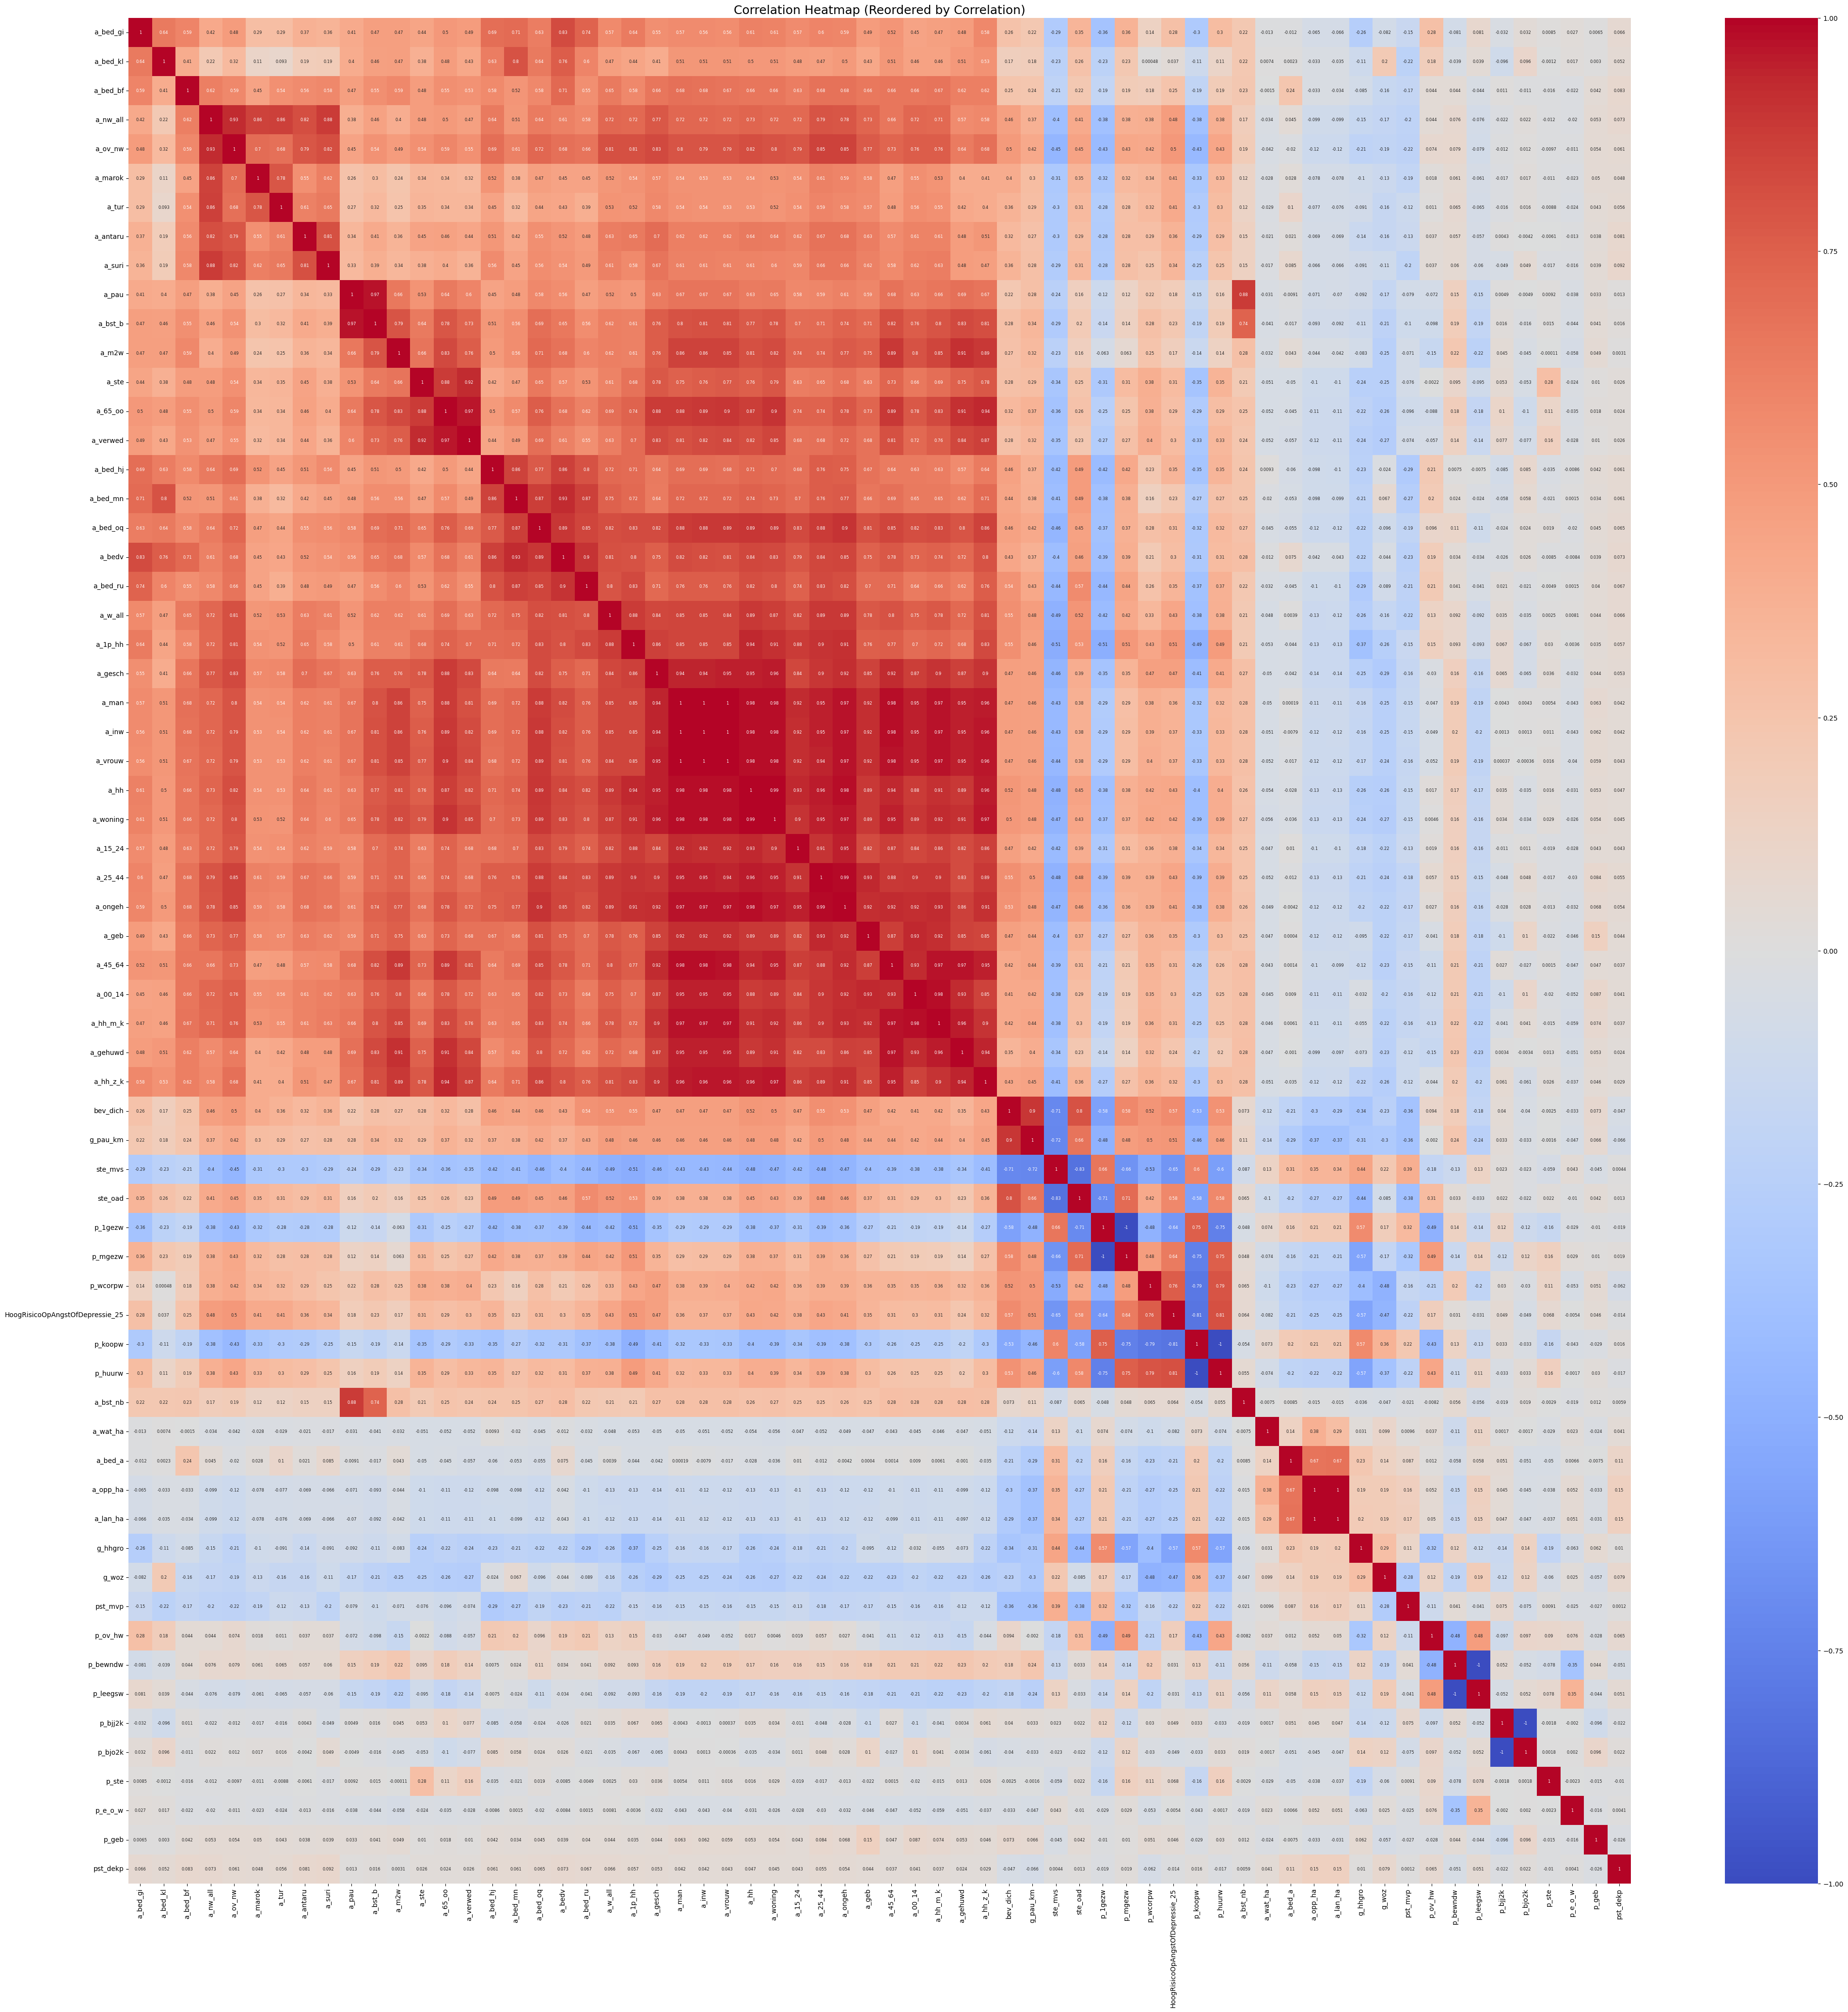

In [ ]:
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

# Calculate the correlation matrix and the distance matrix
corr_matrix = df.iloc[:, 7:].corr()
corr_distance = 1 - np.abs(corr_matrix)

# Cluster the condensed distance matrix and rearrange the correlation matrix
linkage = sch.linkage(pdist(corr_distance), method='average')
dendrogram_order = sch.dendrogram(linkage, no_plot=True)['leaves']
corr_matrix_reordered = corr_matrix.iloc[dendrogram_order, dendrogram_order]

# Plot the heatmap
plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix_reordered, annot=True, cmap="coolwarm", annot_kws={"size": 6})
plt.title("Correlation Heatmap (Reordered by Correlation)", fontsize=18)
plt.show()

Since some variables have a perfect correlations with other variables, only one is kept. For instance, the variables a_inw, a_vrouw and a_man, indicating the general population and that of men and women have a perfect correlation, only a_vrouw is kept.

In [ ]:
columns_to_remove = ["a_inw" , "a_man" ,"p_mgezw", "p_leegsw", "p_huurw", "p_bjo2k", "a_opp_ha"]

# Drop the columns from the DataFrame
df = df.drop(columns=columns_to_remove)

As the distribution of many variables is right skewed, a cubic root transformation was applied to better align them with a standard distribution.

In [ ]:
columns_to_transform = ["a_vrouw", "ind_wbi", "a_00_14","a_15_24", "a_25_44", "a_45_64", "a_65_oo", "a_ongeh", "a_gehuwd", "a_gesch", "a_verwed", "a_w_all",
    "a_nw_all", "a_marok", "a_antaru", "a_suri", "a_tur", "a_ov_nw", "a_geb", "p_geb", "a_ste", "p_ste", "a_hh", "a_1p_hh", "a_hh_z_k",
    "a_hh_m_k", "g_hhgro", "a_woning", "g_woz", "p_1gezw", "p_wcorpw", "p_ov_hw", "p_e_o_w", "a_bedv", "a_bed_a", "a_bed_bf", "a_bed_gi",
    "a_bed_hj", "a_bed_kl", "a_bed_mn", "a_bed_oq", "a_bed_ru", "a_pau", "a_bst_b", "a_bst_nb", "g_pau_km", "a_m2w", "a_lan_ha", "a_wat_ha",
    "pst_dekp", "ste_oad"]

for column in columns_to_transform:
    df[column] = np.cbrt(df[column])

df["a_bst_nb"] = np.cbrt(df["a_bst_nb"])

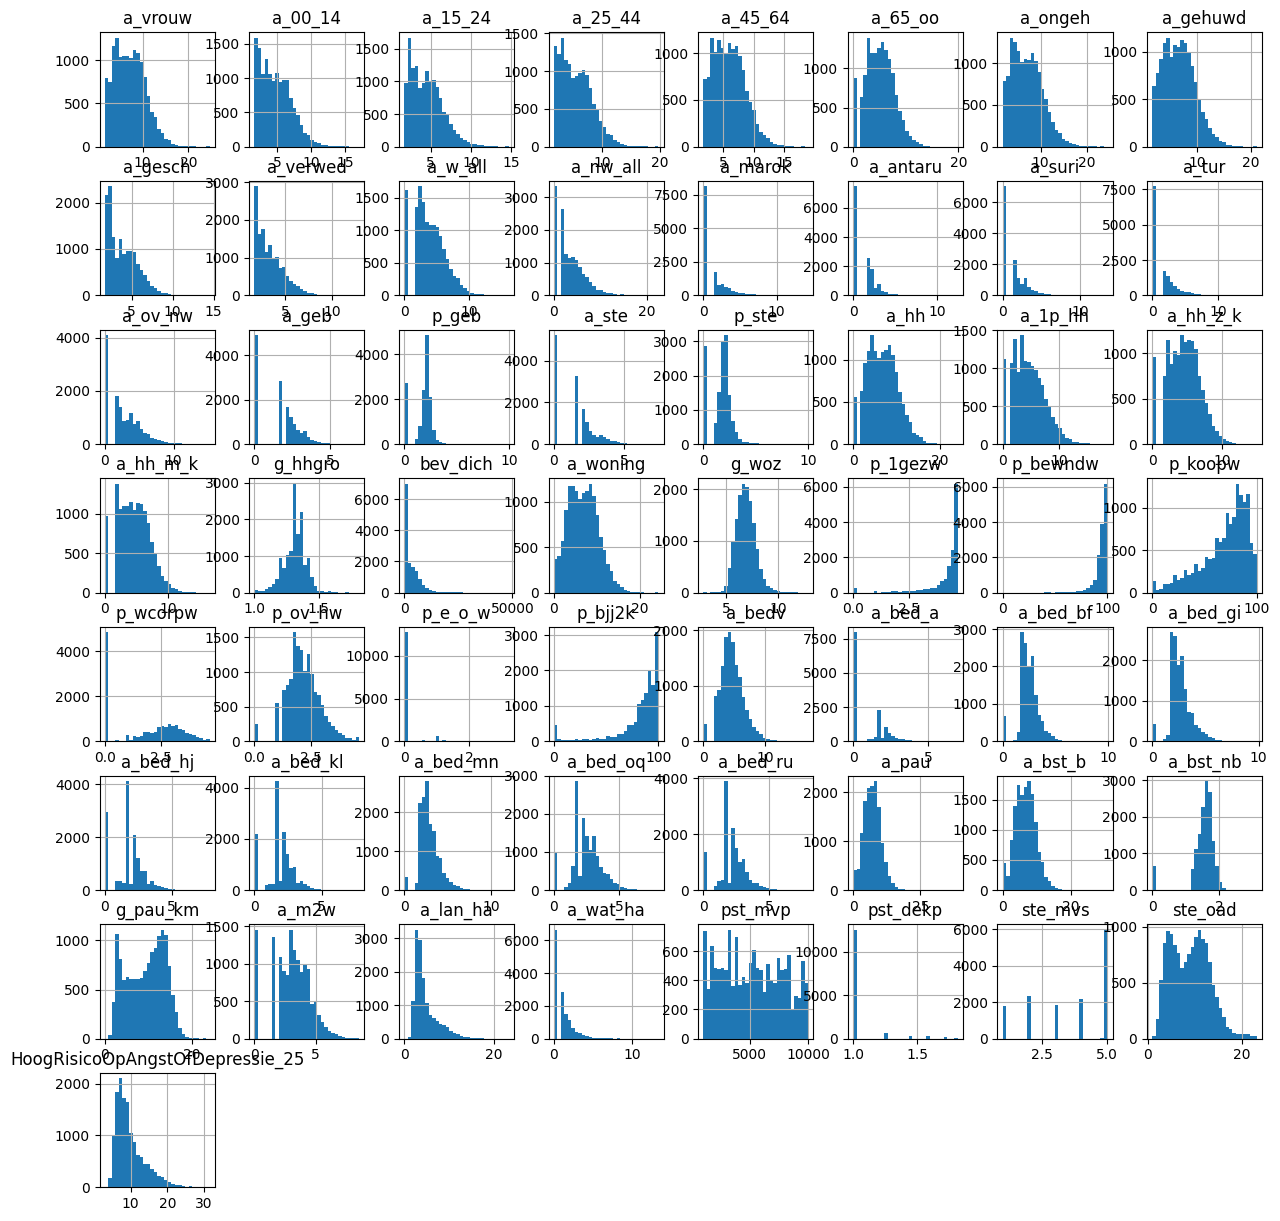

In [ ]:
distribution_plots = df.iloc[:, 7:].hist(figsize=(15, 15), bins=30)

plt.show()

## Modelling and Evaluation

In [ ]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    adj_r2 = 1 - (1-r2_score(y_test, predictions)) * (len(y)-1)/(len(y)-X.shape[1]-1)

    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"R^2 Score: {r2}")
    print(f"Adjusted R^2 Score: {adj_r2}")

In [ ]:
# Separate dataset into input and output variables, excluding descriptive identifiers
X = df.drop(["gwb_code_8", "gwb_code_10", "regio", "gm_naam", "recs","gwb_code", 'HoogRisicoOpAngstOfDepressie_25', "ind_wbi"], axis=1)
y = df['HoogRisicoOpAngstOfDepressie_25']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=62)

In [ ]:
from sklearn.pipeline import make_pipeline

# Create a pipeline with standard scaling and linear regression
regression = make_pipeline(StandardScaler(), LinearRegression())
ols = regression.fit(X_train, y_train)

# Train and evaluate the Linear model
evaluate(ols, X_test, y_test)

Mean Squared Error (MSE): 2.2691741337653415
Mean Absolute Error (MAE): 1.0516611719167837
R^2 Score: 0.8532739619355825
Adjusted R^2 Score: 0.8526880204015592


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=46, shuffle=True)

In [ ]:
ridge_param_grid = {'alpha': np.logspace(-3, 3, 30)}
print(ridge_param_grid)

{'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])}


In [ ]:
# Perform grid search with 10-fold cross-validation
ridge_grid = GridSearchCV(Ridge(), ridge_param_grid, return_train_score=True, cv=10)
ridge_grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.61026203e-03, 2.59294380e-03, 4.17531894e-03,
       6.72335754e-03, 1.08263673e-02, 1.74332882e-02, 2.80721620e-02,
       4.52035366e-02, 7.27895384e-02, 1.17210230e-01, 1.88739182e-01,
       3.03919538e-01, 4.89390092e-01, 7.88046282e-01, 1.26896100e+00,
       2.04335972e+00, 3.29034456e+00, 5.29831691e+00, 8.53167852e+00,
       1.37382380e+01, 2.21221629e+01, 3.56224789e+01, 5.73615251e+01,
       9.23670857e+01, 1.48735211e+02, 2.39502662e+02, 3.85662042e+02,
       6.21016942e+02, 1.00000000e+03])},
             return_train_score=True)

In [ ]:
# Print and extract the optimal value of alpha
print(f"The optimal value of alpha is {ridge_grid.best_params_.get("alpha")} which obtained a score of {ridge_grid.best_score_} ")

The optimal value of alpha is 1.2689610031679222 which obtained a score of 0.8444814536631549 


In [ ]:
# Train and evaluate the final Ridge model with the optimal alpha value
pipe = make_pipeline(StandardScaler(), Ridge(alpha=ridge_grid.best_params_.get("alpha")))
ridge = pipe.fit(X_train, y_train)

evaluate(ridge, X_test, y_test)

Mean Squared Error (MSE): 2.4392962503293703
Mean Absolute Error (MAE): 1.0576423099938232
R^2 Score: 0.8468287842154847
Adjusted R^2 Score: 0.8462171042551386


In [ ]:
# Perform grid search with 10-fold cross-validation to tune max_depth for a Random Forest Regressor

from sklearn.ensemble import RandomForestRegressor
param_grid = {'max_depth': [1, 3, 5, 7, 10, 25, 50, None]}
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=10)
grid_search.fit(X_train, y_train)

best_max_depth = grid_search.best_params_['max_depth']

best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")
best_model = grid_search.best_estimator_
best_accuracy = grid_search.best_score_
print(f"Best Cross-Validation Accuracy: {best_accuracy:.2f}")

Best Parameters: {'max_depth': 50}
Best Cross-Validation Accuracy: 0.86


In [ ]:
# Train and evaluate the final Random Forest Regressor with the optimal max_depth value
R_forest = RandomForestRegressor(max_depth=best_max_depth, random_state=42, n_estimators=500)
R_forest.fit(X_train, y_train)

print("Random Forest Regressor Model Performance:")
evaluate(R_forest, X_test, y_test)

Random Forest Regressor Model Performance:
Mean Squared Error (MSE): 2.259912144194091
Mean Absolute Error (MAE): 0.9929630340909088
R^2 Score: 0.8580928861569562
Adjusted R^2 Score: 0.8575261887045416


The three regression models used to understand the connection between the features and the target variable can be compared using R2 scores. The Linear Regression achieved an R2 score of 0.852, overall indicating a strong fit to the data. The Ridge Regression, due to its regularization of coefficients, fit the data with a R2 score of 0.846, reducing model complexity but also ideally decreasing overfitting. The Random Forest Regressor, using 500 trees with a maximum depth of 50, achieved the highest R2 score: 0.857.


Text(0.5, 0, 'Relative Importance')

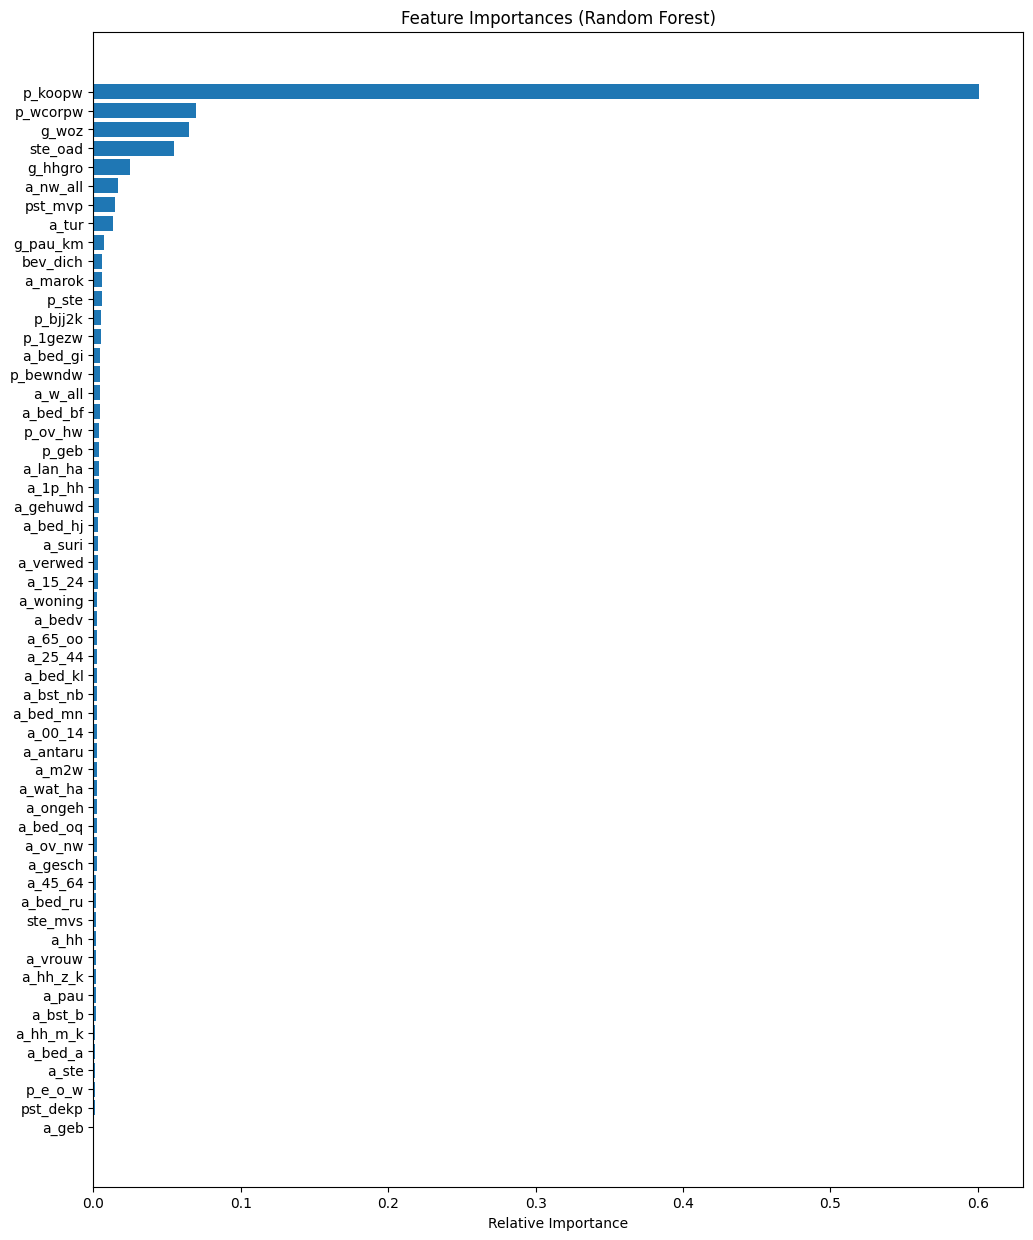

In [ ]:
# Extact and plot feature importances
variables = X.columns
importances = R_forest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 15))
plt.title('Feature Importances (Random Forest)')
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), variables[indices])
plt.xlabel('Relative Importance')

The values of feature importance identified by the Random Forest regressor provide insights into the variables most strongly associated with the target variable (high risk of depression or anxiety). The most significant feature is the percentage of owner-occupied homes; this indicates a strong correlation between housing ownership and mental health risks in the Netherlands, which is in fact 0.81. The second most important feature, even though much less significant than the first, represents the percentage of homes owned by housing corporations instead of private individuals.


In the same manner, the feature average home value might also reflect the economic environment and through that be linked to mental health challenges: neighborhoods with higher home values might offer better infrastructure, services and living conditions that mitigate mental health risks. The surrounding address density is also an indicator of urban areas (CBS, n.d.) which are often crowded, polluted and noisy. This could possibly contribute to a higher risk of mental health issues. Similarly, the household size is shown to influence mental health risk possibly because of similar reasons of overcrowding and economical disadvantages. Overall, the top five features identified by the model are directly related to housing (and its costs), home ownership, and urbanization, which thus seem to reflect financial stability and urban living.


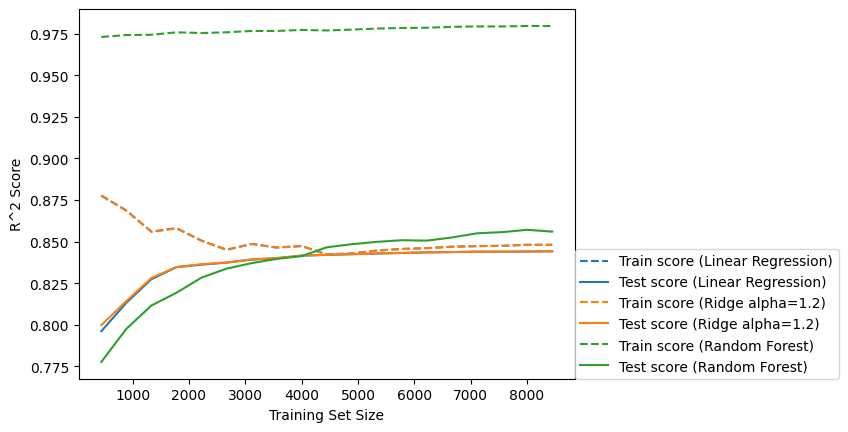

In [ ]:
from sklearn.model_selection import learning_curve
def plot_learningcurve(estimator, label):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=5, train_sizes=np.linspace(0, 1, 20)[1:])

    # Calculate mean scores across cross-validation folds
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    line, = plt.plot(train_sizes, train_mean, '--', label=f"Train score ({label})")
    plt.plot(train_sizes, test_mean, label=f"Test score ({label})", c=line.get_color())

plot_learningcurve(LinearRegression(), "Linear Regression")
plot_learningcurve(Ridge(alpha=1.2689), "Ridge alpha=1.2")
plot_learningcurve(RandomForestRegressor(max_depth=50, random_state=42, n_estimators=100), "Random Forest")

plt.legend(loc=(1,0))
plt.xlabel("Training Set Size")
plt.ylabel("R^2 Score")
plt.show()

To visualize the performance and the behavior of the used models, learning curves were generated for each. The two linear models behaved similarly, which was expected as the alpha of the Ridge model, selected through cross validation, was only 1.268, resulting in a relatively weak penalty. The test scores for the overlapping linear models start plateauing after around 2000 observations, with their R2 scores increasing minimally with larger training sets after that point. On the other hand, the test scores of the random forest regressor steadily improve as the training data size is increased, although this increase slows down with training sets of more than and more than 4000 observations.


## Outlier Detection

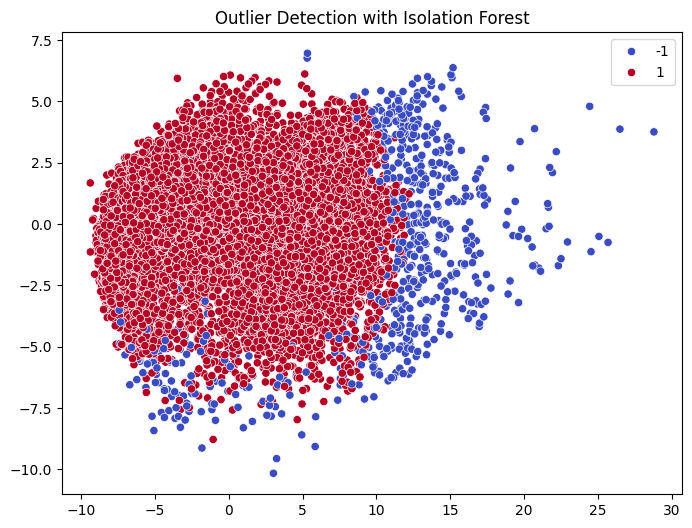

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

X1 = df.iloc[:, 7:]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Fit the Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_scaled)

# Mark the outliers
df['Outliers_IsolationForest'] = outliers

# Reduce data to two dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualize the outliers in the data
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=outliers, palette='coolwarm')
plt.title("Outlier Detection with Isolation Forest")
plt.show()


In [ ]:
# Load dataset with mappings between dutch provinces and municipalities and merge it with the main dataset
municipalities = pd.read_csv("municipalities_v7.csv")
municipalities = municipalities[["municipality", "province"]]
municipalities.rename(columns={"municipality": "gm_naam"}, inplace=True)
df_provinces = df.merge(municipalities, on="gm_naam", how = 'outer')
df_provinces = df_provinces.drop_duplicates()
df_provinces = df_provinces.dropna(subset=['a_vrouw'])
df_provinces = df_provinces.reset_index(drop=True)

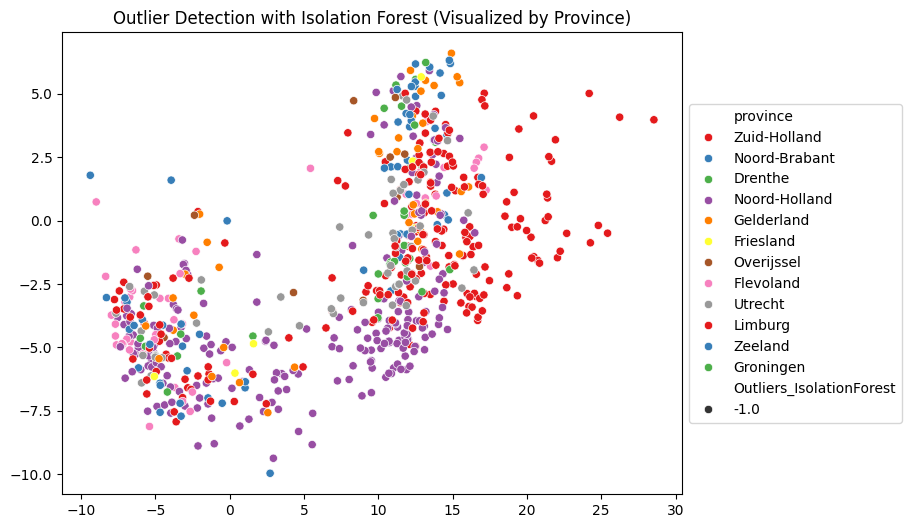

In [ ]:
X1 = df_provinces.iloc[:, 7:64]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X1)

# Fit the Isolation Forest model and mark the outliers
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outliers = iso_forest.fit_predict(X_scaled)
df_provinces['Outliers_IsolationForest'] = outliers

# Filter only the outliers
outlier_df = df_provinces[df_provinces['Outliers_IsolationForest'] == -1]

# Reduce data to two dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# visualize outliers by province
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_provinces['province'], palette='Set1', style=outlier_df['Outliers_IsolationForest'])
plt.title("Outlier Detection with Isolation Forest (Visualized by Province)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:
# Calculate the proportion and number of outliers in each province

outliers = df_provinces[df_provinces['Outliers_IsolationForest'] == -1]
outlier_proportion = (outliers['province'].value_counts() / df_provinces['province'].value_counts()).sort_values(ascending=False)

print("Proportion of outliers in each province\n")
print(f"{outlier_proportion}\n")


print("Number of outliers in each province\n")
print(outliers['province'].value_counts())

Proportion of outliers in each province

province
Flevoland        0.163522
Noord-Holland    0.108523
Zuid-Holland     0.091204
Utrecht          0.057889
Groningen        0.057644
Noord-Brabant    0.029111
Limburg          0.026077
Gelderland       0.024490
Drenthe          0.014749
Overijssel       0.011278
Zeeland          0.011038
Friesland        0.007463
Name: count, dtype: float64

Number of outliers in each province

province
Noord-Holland    219
Zuid-Holland     197
Noord-Brabant     57
Flevoland         52
Utrecht           51
Gelderland        42
Limburg           23
Groningen         23
Overijssel        12
Drenthe           10
Friesland          6
Zeeland            5
Name: count, dtype: int64


In order to identify and analyze outliers among the neighborhoods based on their statistics, an isolation forest algorithm was applied. This allowed for the visualization of outliers and their distribution among different Dutch provinces. In total, the Isolation Forest model identified 697 outliers out of the 14080 observations, which are represented as blue dots. By plotting these outliers by province, we can gain insight into regional variance. In fact, the color coded figure 
shows the distribution of outliers by province, which allows us to identify some clusters. For instance, North and South Holland exhibit the highest number of outliers with approximately 200 each, representing about 10% of their respective observations. These tend to be mainly situated respectively in the  bottom-left and top-right quadrants of the visualization, highlighting regional trends. Another province with a high percentage of outliers was Flevoland, with 16% among all observations.


In [ ]:
df_provinces['weighted_risk'] = df_provinces['HoogRisicoOpAngstOfDepressie_25'] * df_provinces['a_vrouw']

# Calculate the weighted average for a group
def calculate_weighted_average(group):
    weighted_sum = group['weighted_risk'].sum()
    total_weight = group['a_vrouw'].sum()
    return weighted_sum / total_weight
risk_by_province = df_provinces.groupby('province').apply(calculate_weighted_average).reset_index(name='HoogRisicoOpAngstOfDepressie')

print(risk_by_province)

         province  HoogRisicoOpAngstOfDepressie
0         Drenthe                      8.902909
1       Flevoland                     12.505215
2       Friesland                      8.937293
3      Gelderland                      9.755257
4       Groningen                     11.194004
5         Limburg                     11.355162
6   Noord-Brabant                     10.249574
7   Noord-Holland                     11.966961
8      Overijssel                      9.642392
9         Utrecht                     10.228568
10        Zeeland                      9.321100
11   Zuid-Holland                     11.916536


/var/folders/b7/12v2nzlx7w5cn2y9qwwd4mf00000gn/T/ipykernel_31462/1987238109.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  risk_by_province = df_provinces.groupby('province').apply(calculate_weighted_average).reset_index(name='HoogRisicoOpAngstOfDepressie')
